# Embedding large data sets

Embedding large data sets typically requires more care. Using various tricks described in *preserving_global_structure* can become quite slow to run. Instead, we can take a smaller, manageable sample of our data set, obtain a good visualization of that. Then, we can add the remaining points to the embedding and use that as our initialization.

Remember that the initialization largely affects the structure of the embedding. This way, our initialization provides the global structure for the embedding, and the subsequent optimization can focus on preserving local strucutre.

In [1]:
import gzip
import pickle

import numpy as np
import openTSNE
from examples import utils

import matplotlib.pyplot as plt
%matplotlib inline

## Load data

The preprocessed data set can be downloaded from http://file.biolab.si/opentsne/benchmark/10x_mouse_zheng.pkl.gz.

In [2]:
%%time
with gzip.open("data/10x_mouse_zheng.pkl.gz", "rb") as f:
    data = pickle.load(f)

x = data["pca_50"]
y = data["CellType1"]

CPU times: user 5.88 s, sys: 2.54 s, total: 8.42 s
Wall time: 8.42 s


In [3]:
print("Data set contains %d samples with %d features" % x.shape)

Data set contains 1306127 samples with 50 features


In [4]:
def plot(x, y, **kwargs):
    fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
    alpha = kwargs.pop("alpha", 0.1)
    utils.plot(
        x,
        np.zeros_like(y),
        ax=ax[0],
        colors={0: "k"},
        alpha=alpha,
        draw_legend=False,
        **kwargs,
    )
    utils.plot(
        x,
        y,
        ax=ax[1],
        colors=utils.MOUSE_10X_COLORS,
        alpha=alpha,
        draw_legend=False,
        **kwargs,
    )

In [5]:
def rotate(degrees):
    phi = degrees * np.pi / 180
    return np.array([
        [np.cos(phi), -np.sin(phi)],
        [np.sin(phi), np.cos(phi)],
    ])

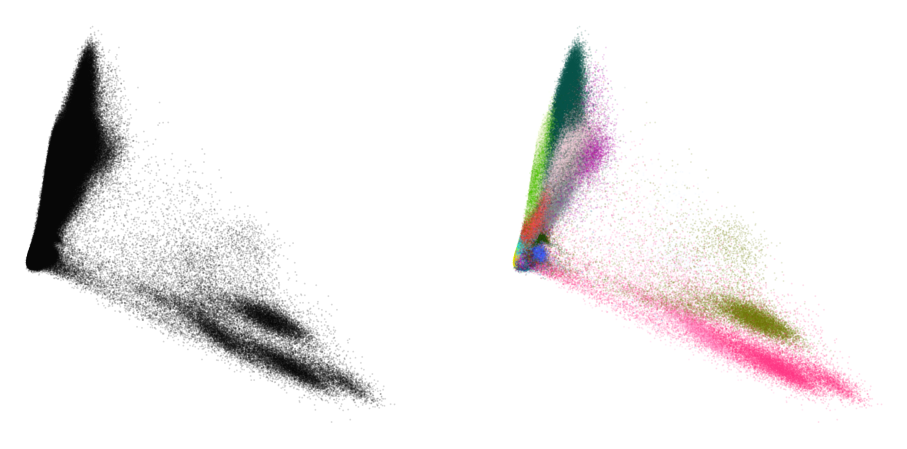

In [6]:
plot(x, y)

We'll also precompute the full affinities, since we'll be needing it in several places throughout the notebook, and can take a long time to run.

In [7]:
%%time
aff50 = openTSNE.affinity.PerplexityBasedNN(
    x,
    perplexity=50,
    n_jobs=32,
    random_state=0,
)

CPU times: user 52min 31s, sys: 1min 21s, total: 53min 53s
Wall time: 8min 2s


In [8]:
%%time
aff500 = openTSNE.affinity.PerplexityBasedNN(
    x,
    perplexity=500,
    n_jobs=32,
    random_state=0,
)

CPU times: user 5h 36min 15s, sys: 8min 53s, total: 5h 45min 8s
Wall time: 39min 40s


## Standard t-SNE

First, let's see what standard t-SNE does.

In [9]:
# Because we're given the data representation as the top 50 principal components
# we can just use the top 2 components as the initilization. There is no sense in
# calculating PCA on a PCA representation
init = openTSNE.initialization.rescale(x[:, :2])

In [10]:
%%time
embedding_standard = openTSNE.TSNE(
    n_jobs=32,
    verbose=True,
).fit(affinities=aff50, initialization=init)

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=32, verbose=True)
--------------------------------------------------------------------------------
===> Running optimization with exaggeration=12.00, lr=108843.92 for 250 iterations...
Iteration   50, KL divergence 8.0820, 50 iterations in 49.5503 sec
Iteration  100, KL divergence 7.8989, 50 iterations in 52.9387 sec
Iteration  150, KL divergence 7.8314, 50 iterations in 52.7589 sec
Iteration  200, KL divergence 7.8026, 50 iterations in 53.2414 sec
Iteration  250, KL divergence 7.7870, 50 iterations in 52.9956 sec
   --> Time elapsed: 261.49 seconds
===> Running optimization with exaggeration=1.00, lr=1306127.00 for 500 iterations...
Iteration   50, KL divergence 5.7583, 50 iterations in 59.4852 sec
Iteration  100, KL divergence 5.4506, 50 iterations in 60.9192 sec
Iteration  150, KL divergence 5.2984, 50 iterations in 63.3280 sec
Iteration  200, KL divergence 5.2018, 50 

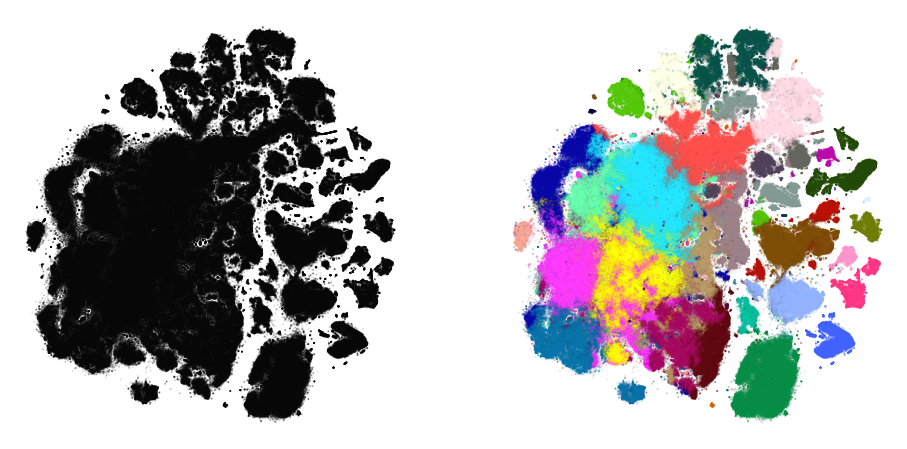

In [11]:
plot(embedding_standard, y)

This doesn't look too great. The cluster separation is quite poor and the visualization is visually not very appealing.

## Using larger exaggeration

Exaggeration can be used in order to get better separation between clusters. Let's see if that helps.

In [12]:
%%time
embedding_exag = openTSNE.TSNE(
    exaggeration=4,
    n_jobs=32,
    verbose=True,
).fit(affinities=aff50, initialization=init)

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, exaggeration=4, n_jobs=32, verbose=True)
--------------------------------------------------------------------------------
===> Running optimization with exaggeration=12.00, lr=108843.92 for 250 iterations...
Iteration   50, KL divergence 8.0820, 50 iterations in 51.7397 sec
Iteration  100, KL divergence 7.8994, 50 iterations in 54.2033 sec
Iteration  150, KL divergence 7.8317, 50 iterations in 54.2117 sec
Iteration  200, KL divergence 7.8020, 50 iterations in 55.0897 sec
Iteration   50, KL divergence 6.9432, 50 iterations in 56.7796 sec
Iteration  100, KL divergence 6.8014, 50 iterations in 57.5679 sec
Iteration  150, KL divergence 6.7409, 50 iterations in 56.7147 sec
Iteration  200, KL divergence 6.7068, 50 iterations in 56.3419 sec
Iteration  250, KL divergence 6.6856, 50 iterations in 56.2568 sec
Iteration  300, KL divergence 6.6712, 50 iterations in 56.5754 sec
Iteration  35

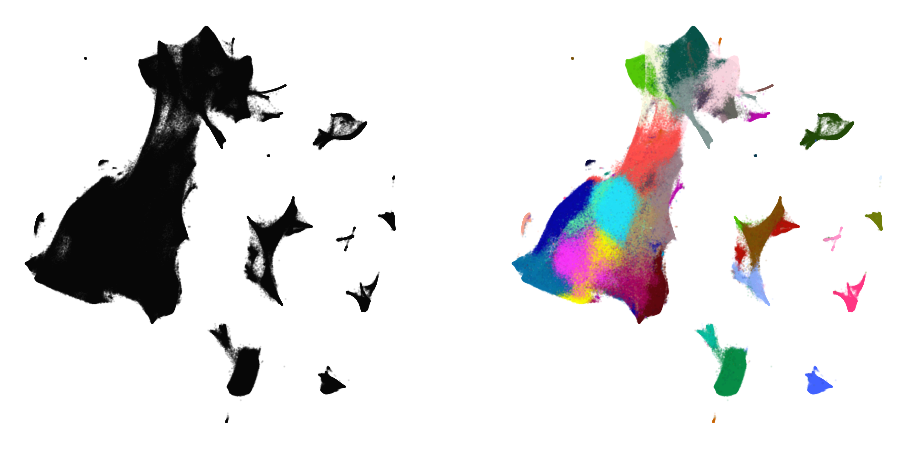

In [13]:
plot(embedding_exag, y)

The separation has improved quite a bit, but many clusters are still intertwined with others.

## Using a larger perplexity

In [14]:
%%time
embedding_aff500 = openTSNE.TSNE(
    n_jobs=32,
    verbose=True,
).fit(affinities=aff500, initialization=init)

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=32, verbose=True)
--------------------------------------------------------------------------------
===> Running optimization with exaggeration=12.00, lr=108843.92 for 250 iterations...
Iteration   50, KL divergence 5.9688, 50 iterations in 216.9035 sec
Iteration  100, KL divergence 5.9218, 50 iterations in 218.9351 sec
Iteration  150, KL divergence 5.8993, 50 iterations in 218.5032 sec
Iteration  200, KL divergence 5.8900, 50 iterations in 223.6785 sec
Iteration  250, KL divergence 5.8854, 50 iterations in 224.3249 sec
   --> Time elapsed: 1102.35 seconds
===> Running optimization with exaggeration=1.00, lr=1306127.00 for 500 iterations...
Iteration   50, KL divergence 3.8664, 50 iterations in 237.2816 sec
Iteration  100, KL divergence 3.6473, 50 iterations in 226.6633 sec
Iteration  150, KL divergence 3.5520, 50 iterations in 235.5178 sec
Iteration  200, KL divergence 3.

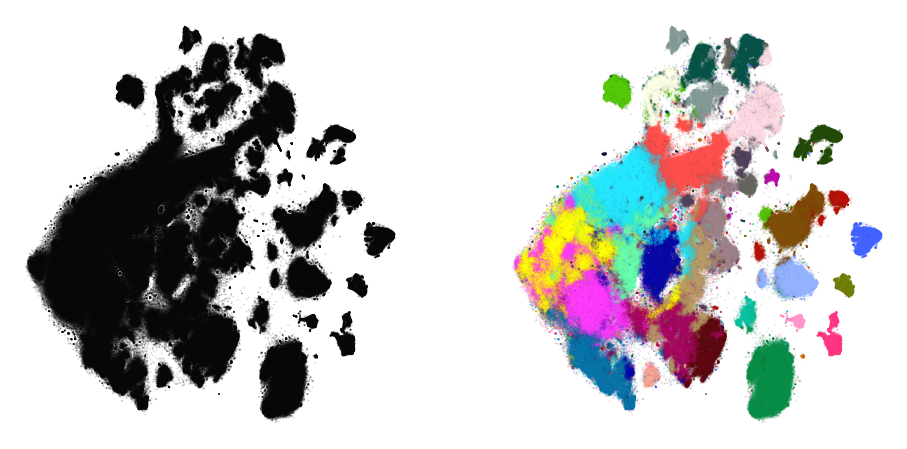

In [15]:
plot(embedding_aff500, y)

## ... with higher exaggeration

In [16]:
%%time
embedding_aff500_exag4 = openTSNE.TSNE(
    exaggeration=4,
    n_jobs=32,
    verbose=True,
).fit(affinities=aff500, initialization=init)

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, exaggeration=4, n_jobs=32, verbose=True)
--------------------------------------------------------------------------------
===> Running optimization with exaggeration=12.00, lr=108843.92 for 250 iterations...
Iteration   50, KL divergence 5.9688, 50 iterations in 215.2427 sec
Iteration  100, KL divergence 5.9218, 50 iterations in 221.4924 sec
Iteration  150, KL divergence 5.8993, 50 iterations in 218.4626 sec
Iteration  200, KL divergence 5.8901, 50 iterations in 216.9501 sec
Iteration  250, KL divergence 5.8855, 50 iterations in 217.3419 sec
   --> Time elapsed: 1089.49 seconds
===> Running optimization with exaggeration=4.00, lr=326531.75 for 500 iterations...
Iteration   50, KL divergence 5.0544, 50 iterations in 216.4466 sec
Iteration  100, KL divergence 4.9857, 50 iterations in 214.6171 sec
Iteration  150, KL divergence 4.9611, 50 iterations in 214.4493 sec
Iteration  200, K

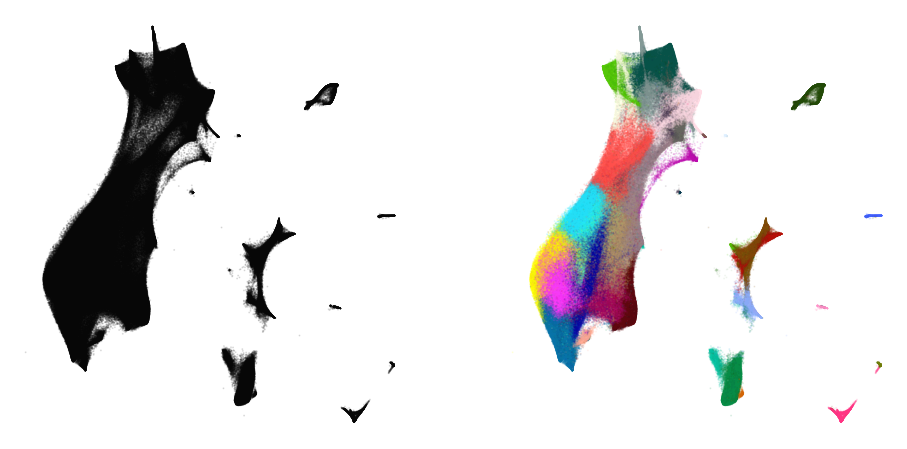

In [17]:
plot(embedding_aff500_exag4, y)

## Initialize via downsampling

We now perform the sample-transform trick we described above.

### Create train/test split

In [18]:
np.random.seed(0)

In [19]:
indices = np.random.permutation(list(range(x.shape[0])))
reverse = np.argsort(indices)

x_sample, x_rest = x[indices[:25000]], x[indices[25000:]]
y_sample, y_rest = y[indices[:25000]], y[indices[25000:]]

### Create sample embedding

In [20]:
%%time
sample_affinities = openTSNE.affinity.PerplexityBasedNN(
    x_sample,
    perplexity=500,
    n_jobs=32,
    random_state=0,
    verbose=True,
)

===> Finding 1500 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 15.41 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 6.54 seconds
CPU times: user 3min 39s, sys: 4.97 s, total: 3min 44s
Wall time: 21.9 s


In [21]:
%time sample_init = openTSNE.initialization.pca(x_sample, random_state=42)

CPU times: user 5.35 s, sys: 657 ms, total: 6.01 s
Wall time: 171 ms


In [22]:
%time sample_embedding = openTSNE.TSNE(n_jobs=32, verbose=True).fit(affinities=sample_affinities, initialization=sample_init)

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=32, verbose=True)
--------------------------------------------------------------------------------
===> Running optimization with exaggeration=12.00, lr=2083.33 for 250 iterations...
Iteration   50, KL divergence 3.0347, 50 iterations in 4.0133 sec
Iteration  100, KL divergence 3.0733, 50 iterations in 3.9727 sec
Iteration  150, KL divergence 3.0691, 50 iterations in 4.0981 sec
Iteration  200, KL divergence 3.0690, 50 iterations in 3.9779 sec
Iteration  250, KL divergence 3.0690, 50 iterations in 3.9779 sec
   --> Time elapsed: 20.04 seconds
===> Running optimization with exaggeration=1.00, lr=25000.00 for 500 iterations...
Iteration   50, KL divergence 1.1925, 50 iterations in 4.2847 sec
Iteration  100, KL divergence 1.1550, 50 iterations in 4.4657 sec
Iteration  150, KL divergence 1.1452, 50 iterations in 4.8737 sec
Iteration  200, KL divergence 1.1407, 50 iterations in

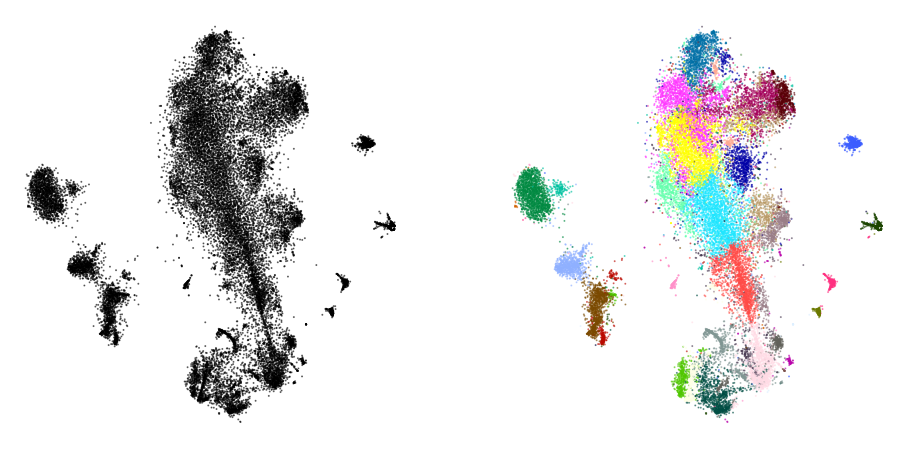

In [23]:
plot(sample_embedding, y[indices[:25000]], alpha=0.5)

### Learn the full embedding

In [24]:
%time rest_init = sample_embedding.prepare_partial(x_rest, k=1, perplexity=1/3)

===> Finding 1 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 174.82 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.67 seconds
CPU times: user 4min 18s, sys: 32.3 s, total: 4min 51s
Wall time: 2min 55s


In [25]:
init_full = np.vstack((sample_embedding, rest_init))[reverse]

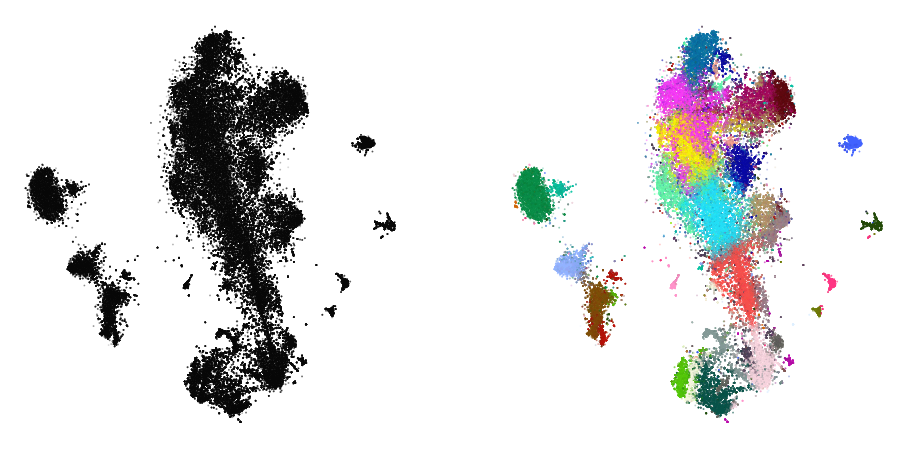

In [26]:
plot(init_full, y)

In [27]:
init_full = init_full / (np.std(init_full[:, 0]) * 10000)
np.std(init_full, axis=0)

array([1.00000000e-04, 1.06471542e-04])

In [28]:
embedding = openTSNE.TSNEEmbedding(
    init_full,
    aff50,
    n_jobs=32,
    verbose=True,
    random_state=42,
)

In [29]:
%time embedding1 = embedding.optimize(n_iter=500, exaggeration=12)

===> Running optimization with exaggeration=12.00, lr=108843.92 for 500 iterations...
Iteration   50, KL divergence 7.9326, 50 iterations in 48.9843 sec
Iteration  100, KL divergence 7.8311, 50 iterations in 51.0335 sec
Iteration  150, KL divergence 7.7772, 50 iterations in 51.2970 sec
Iteration  200, KL divergence 7.7543, 50 iterations in 51.3436 sec
Iteration  250, KL divergence 7.7423, 50 iterations in 51.4951 sec
Iteration  300, KL divergence 7.7350, 50 iterations in 51.2477 sec
Iteration  350, KL divergence 7.7299, 50 iterations in 51.5019 sec
Iteration  400, KL divergence 7.7263, 50 iterations in 51.7564 sec
Iteration  450, KL divergence 7.7237, 50 iterations in 51.6552 sec
Iteration  500, KL divergence 7.7216, 50 iterations in 51.2847 sec
   --> Time elapsed: 511.60 seconds
CPU times: user 2h 22min 35s, sys: 6min 28s, total: 2h 29min 4s
Wall time: 8min 34s


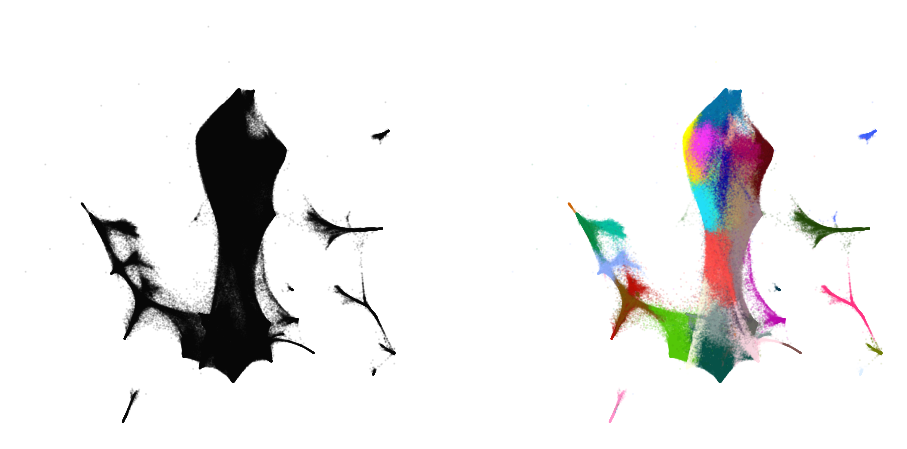

In [30]:
plot(embedding1, y)

In [31]:
%time embedding2 = embedding1.optimize(n_iter=250, exaggeration=4)

===> Running optimization with exaggeration=4.00, lr=326531.75 for 250 iterations...
Iteration   50, KL divergence 6.9325, 50 iterations in 55.0011 sec
Iteration  100, KL divergence 6.8182, 50 iterations in 54.9294 sec
Iteration  150, KL divergence 6.7678, 50 iterations in 54.4471 sec
Iteration  200, KL divergence 6.7398, 50 iterations in 54.4368 sec
Iteration  250, KL divergence 6.7219, 50 iterations in 53.8917 sec
   --> Time elapsed: 272.71 seconds
CPU times: user 1h 13min 35s, sys: 3min 14s, total: 1h 16min 49s
Wall time: 4min 34s


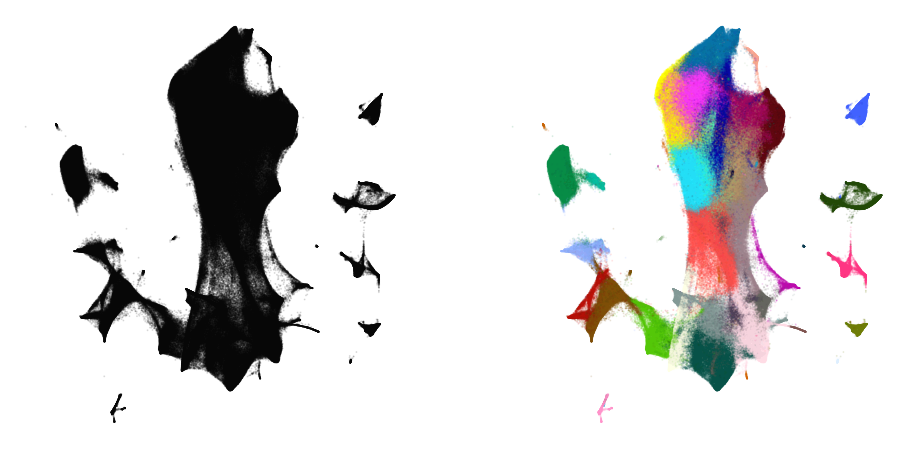

In [32]:
plot(embedding2, y)

In [33]:
%time embedding3 = embedding2.optimize(n_iter=250, exaggeration=4)

===> Running optimization with exaggeration=4.00, lr=326531.75 for 250 iterations...
Iteration   50, KL divergence 6.7076, 50 iterations in 51.7026 sec
Iteration  100, KL divergence 6.6960, 50 iterations in 51.7740 sec
Iteration  150, KL divergence 6.6850, 50 iterations in 51.9709 sec
Iteration  200, KL divergence 6.6749, 50 iterations in 51.9325 sec
Iteration  250, KL divergence 6.6667, 50 iterations in 51.3449 sec
   --> Time elapsed: 258.73 seconds
CPU times: user 1h 9min 44s, sys: 3min 14s, total: 1h 12min 58s
Wall time: 4min 20s


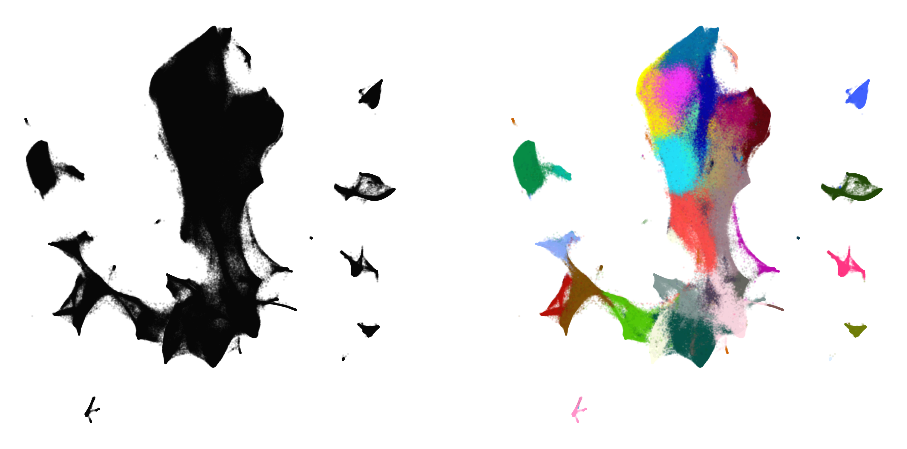

In [34]:
plot(embedding3, y)

In [35]:
%time embedding4 = embedding3.optimize(n_iter=250, exaggeration=4)

===> Running optimization with exaggeration=4.00, lr=326531.75 for 250 iterations...
Iteration   50, KL divergence 6.6604, 50 iterations in 51.5464 sec
Iteration  100, KL divergence 6.6554, 50 iterations in 51.8160 sec
Iteration  150, KL divergence 6.6514, 50 iterations in 51.7537 sec
Iteration  200, KL divergence 6.6484, 50 iterations in 51.8397 sec
Iteration  250, KL divergence 6.6455, 50 iterations in 51.6008 sec
   --> Time elapsed: 258.56 seconds
CPU times: user 1h 11min 20s, sys: 3min 14s, total: 1h 14min 35s
Wall time: 4min 20s


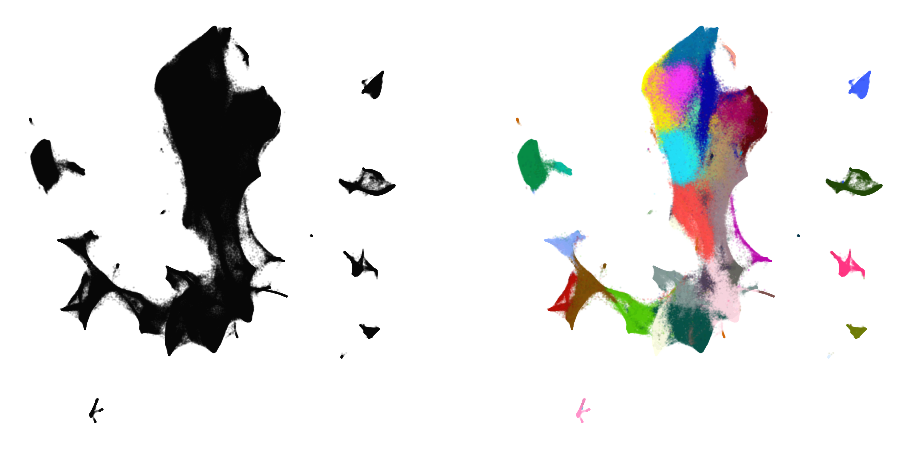

In [36]:
plot(embedding4, y)

## Comparison to UMAP

In [37]:
from umap import UMAP

/home/ppolicar/miniconda3/envs/tsne/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ppolicar/miniconda3/envs/tsne/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ppolicar/miniconda3/envs/tsne/lib/python3.10/site-packages/uma

In [38]:
umap = UMAP(n_neighbors=15, min_dist=0.1, random_state=1)

In [39]:
%time embedding_umap = umap.fit_transform(x)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


CPU times: user 9h 39min 56s, sys: 1h 17min 49s, total: 10h 57min 45s
Wall time: 1h 21min 7s


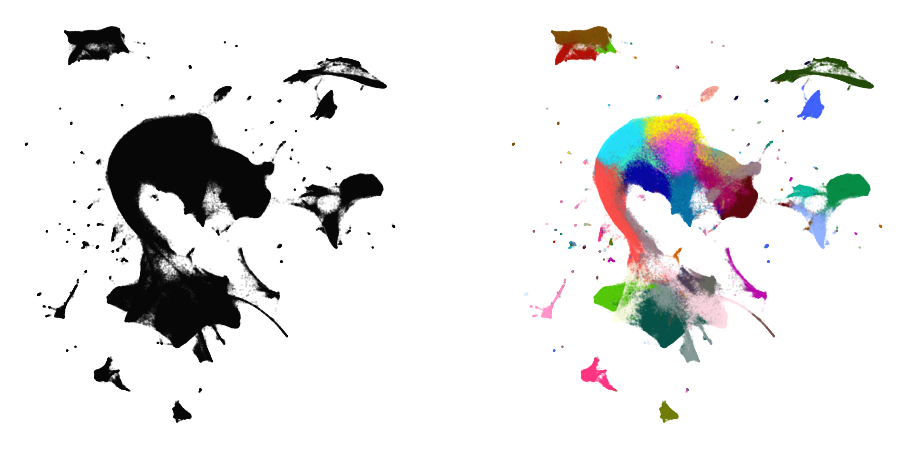

In [40]:
plot(embedding_umap, y)